In [59]:
from typing import Dict, List, Union
import os
import glob
import pickle
from tqdm import tqdm

import numpy as np
import torch
from torch.nn.utils import prune
import matplotlib.pyplot as plt

from model import Model
from metrics import Regression
from utils.parse_logs import parse_metrics

In [2]:
def early_stopping(
    key: str,
    training: Dict[str, List[Union[int, float]]],
    validation: Dict[str, List[Union[int, float]]],
    testing: Dict[str, List[Union[int, float]]],
):

    best_iter = np.argmax(validation[key])
    best_epoch = validation['Epoch'][best_iter]
    yield best_epoch
    for split in (training, validation, testing):
        try:
            split_idx = split['Epoch'].index(best_epoch)
            yield {metric: split[metric][split_idx] if metric is not None else None for metric in split.keys()}
        except ValueError:
            yield None

In [3]:
root = '.\\results\\pruning\\'
results = dict()

for fn in glob.glob(root + '**/logs', recursive=True):
    dataset, gnn, dropout, prob, _ = fn.lstrip(root).split('\\')
    prob = float(prob.split('=')[1]) / 100.
    results[(gnn, dropout, prob)] = parse_metrics(fn)

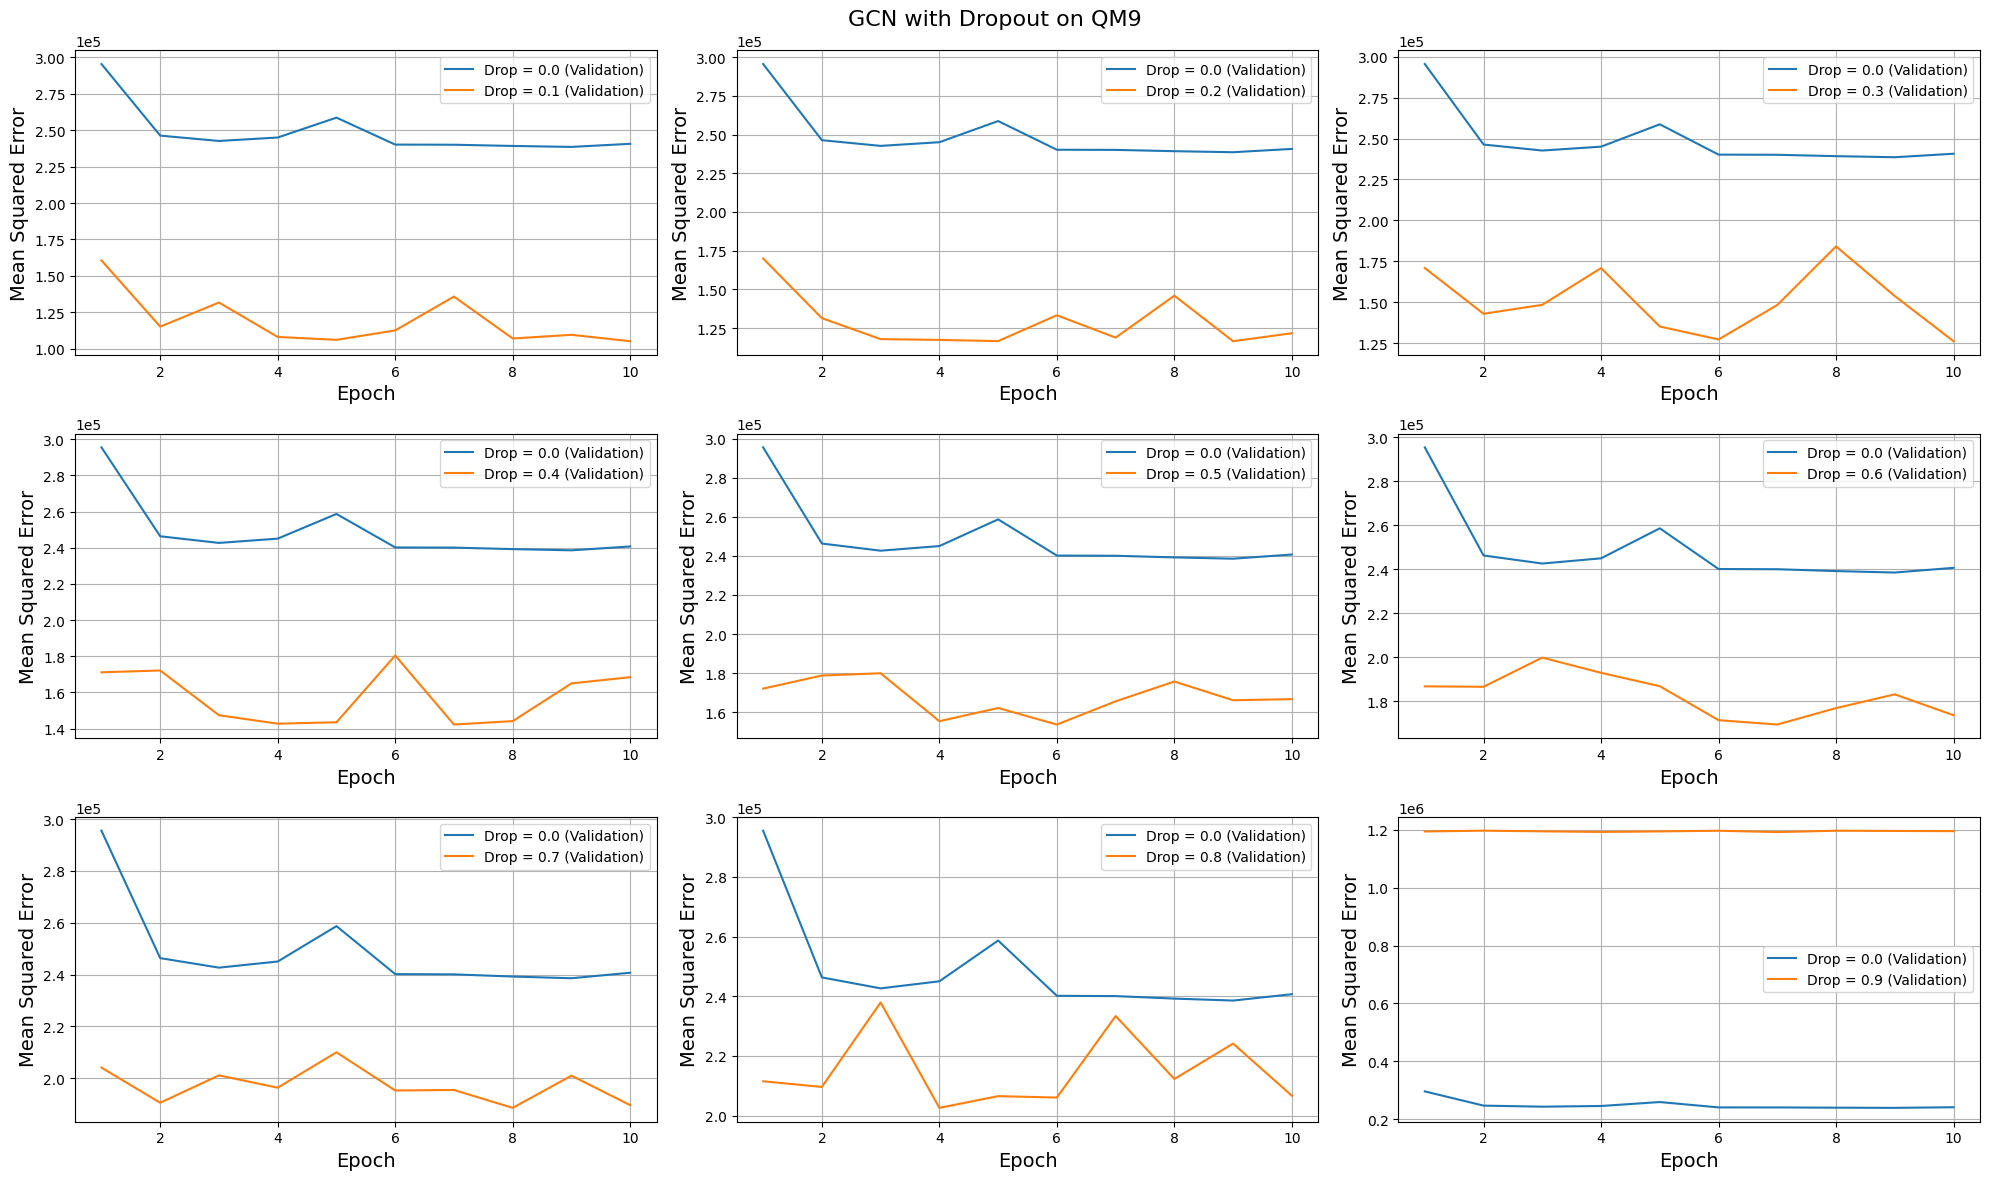

In [4]:
key = 'Mean Squared Error'
fontdict = {'font':'serif', 'size':24}

fig, axs = plt.subplots(3, 3, figsize=(20, 12))
for i in range(9):
    prob = (i+1) / 10.
    ax = axs[i//3, i%3]
    for p in (0.0, prob):
        training, validation, _ = results[('GCN', 'Dropout', p)]
        # ax.plot(range(1, 11), training[key], label=f'Drop = {p} (Training)')
        ax.plot(range(1, 11), validation[key], label=f'Drop = {p} (Validation)')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(key, fontsize=14)
    ax.grid()
    ax.legend()

fig.suptitle(f'GCN with Dropout on QM9', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [5]:
dataset = 'QM9'
model = 'GCN'
dropout = 'Dropout'

best_epochs = dict()

print('Best Epochs:')
for prob in range(0, 10):
    prob = prob / 10.
    _, validation, _ = results[(model, dropout, prob)]
    metric = validation['Mean Squared Error']
    best_epoch = np.argmin(metric) + 1
    best_epochs[prob] = best_epoch
    print(f'\tDrop Prob = {prob}: Epoch {best_epoch}')
    for epoch in range(1, 10):
        if epoch != best_epoch:
            fn = os.path.join(root, dataset, model, dropout, f'prob={int(100*prob)}', f"epoch-{str(epoch).rjust(2,'0')}.pt")
            if os.path.isfile(fn):
                os.remove(fn)

Best Epochs:
	Drop Prob = 0.0: Epoch 9
	Drop Prob = 0.1: Epoch 10
	Drop Prob = 0.2: Epoch 9
	Drop Prob = 0.3: Epoch 10
	Drop Prob = 0.4: Epoch 7
	Drop Prob = 0.5: Epoch 6
	Drop Prob = 0.6: Epoch 7
	Drop Prob = 0.7: Epoch 8
	Drop Prob = 0.8: Epoch 4
	Drop Prob = 0.9: Epoch 7


In [106]:
def parameters_to_prune(model):

    parameters_to_prune = list()
    for gcn_layer in model.message_passing:
        parameters_to_prune.append((gcn_layer.lin, 'weight'))
        if gcn_layer.bias is not None:
            parameters_to_prune.append((gcn_layer, 'bias'))
    for ffn_layer in model.readout.ffn:
        parameters_to_prune.append((ffn_layer, 'weight'))
        parameters_to_prune.append((ffn_layer, 'bias'))

    return parameters_to_prune

In [110]:
dataset = 'QM9'
gnn = 'GCN'
dropout = 'Dropout'
prob = 0.1
best_epoch = best_epochs[prob]

config_fn = os.path.join(root, dataset, gnn, dropout, f'prob={int(100*prob)}', 'config.pkl')
with open(config_fn, 'rb') as f:
    config = pickle.load(f)

loader_fn = os.path.join(root, dataset, gnn, dropout, f'prob={int(100*prob)}', 'test-loader.pt')
test_loader = torch.load(loader_fn)

model_fn = os.path.join(root, dataset, gnn, dropout, f'prob={int(100*prob)}', f"epoch-{str(best_epoch).rjust(2,'0')}.pt")
pruning_test_metrics = dict()
pruning_ratios = np.linspace(0.0, 0.95, 20)

for pruning_ratio in pruning_ratios:

    model = Model(config['num-features'], config['output-dim'], config['cmd-line-args']).to(config['device'])
    model.load_state_dict(torch.load(model_fn))
    prune.global_unstructured(parameters_to_prune(model), pruning_method=prune.L1Unstructured, amount=pruning_ratio)

    metrics = Regression(model.readout.ffn[-1].out_features)
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_loader):
            out = model(batch.x, batch.edge_index, batch.batch)
            metrics.compute_loss(out, batch.y)
        test_metrics = metrics.compute_metrics()

    pruning_test_metrics[pruning_ratio] = test_metrics

100%|██████████| 491/491 [00:32<00:00, 14.99it/s]


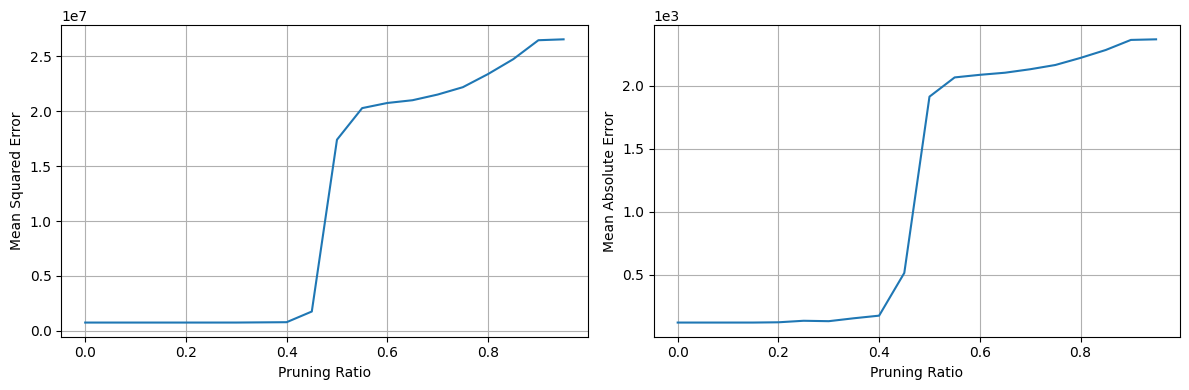

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

x = pruning_ratios

for ax, reg_metric in zip(axs, ('Mean Squared Error', 'Mean Absolute Error')):
    y = [value for pruning_ratio in x for metric, value in pruning_test_metrics[pruning_ratio] if metric == reg_metric]   
    ax.plot(x, y)
    ax.set_xlabel('Pruning Ratio', fontsize=10)
    ax.set_ylabel(reg_metric, fontsize=10)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.grid()

fig.tight_layout()
plt.show()